[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frhack/oli_ai/blob/main/notebooks/oli_ai_programmazione.ipynb)

# MNIST - Riconoscimento di cifre con il metodo della similarità coseno

Questo notebook mostra come riconoscere cifre scritte a mano usando un semplice metodo basato sulla similarità coseno. Utilizzeremo il famoso dataset MNIST che contiene 70.000 immagini di cifre scritte a mano (da 0 a 9).

## Formato delle immagini digitali

Nel dataset MNIST, ogni immagine è rappresentata come una matrice di 28×28 pixel (totale 784 pixel). Ogni pixel contiene un valore numerico che rappresenta l'intensità di grigio:
- 0 rappresenta il bianco
- 255 rappresenta il nero
- I valori intermedi sono diverse tonalità di grigio

Quando elaboriamo queste immagini, possiamo:
1. Lavorare con la matrice 28×28 (utile per visualizzazione)
2. "Appiattire" l'immagine in un vettore di 784 elementi (utile per calcoli matematici)

## Train set e Test set: Perché dividiamo i dati?

Nel machine learning, dividiamo sempre i dati in almeno due gruppi:
- **Train set (dati di addestramento)**: Usato per insegnare al modello. Nel nostro caso, useremo questi dati per calcolare le immagini medie di ogni cifra.
- **Test set (dati di test)**: Usato per valutare quanto bene il modello generalizza su dati mai visti prima.

Questa divisione è fondamentale perché vogliamo verificare che il modello funzioni bene su dati nuovi e non semplicemente "memorizzi" i dati di addestramento. Nel dataset MNIST, i dati sono già divisi in:
- 60.000 immagini di addestramento
- 10.000 immagini di test

In [1]:
from keras.datasets import mnist
from matplotlib import pyplot as plt
from oli_ai.mnist_lib import *
import numpy as np
from numpy.linalg import norm
from numpy import dot

data = mnist.load_data()
(X_train, y_train), (X_test, y_test) = data
print(len(X_train))
print(len(X_test))
print(X_train[0].shape)
print(y_train[0])  
#X_train.shape


2025-05-21 10:05:05.677199: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 10:05:06.018430: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 10:05:06.023691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-21 10:05:08.233833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


60000
10000
(28, 28)
5


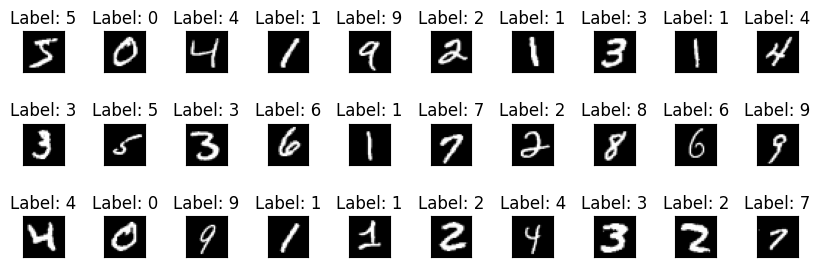

In [ ]:

plot_imgs_labels(X_train,y_train, 3, 10)


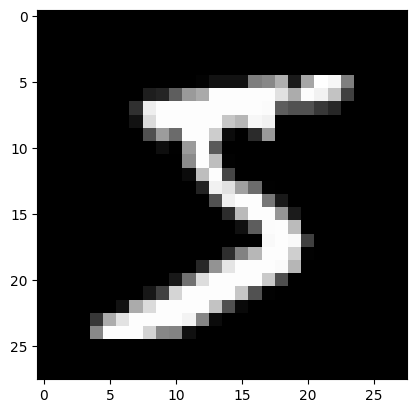

0
170


In [18]:
immagine_0 = X_train[0] 
plot_img(immagine_0)

print(immagine_0[0][0])
print(immagine_0[6][12])




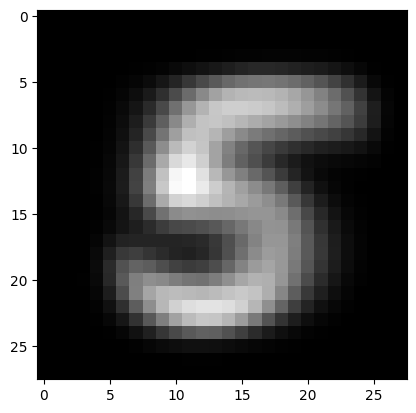

In [4]:
cifre_5 = X_train[y_train==5]
media_cifra_5 = np.average(X_train[y_train==5],0)

plot_img(media_cifra_5)

## Fase 1: Apprendimento (Training)

Durante la fase di apprendimento, il modello "impara" dai dati di addestramento. Nel nostro caso, il modello è molto semplice:

1. Per ogni cifra (0-9), calcoliamo un'"immagine media" usando tutti gli esempi di quella cifra nel set di addestramento
2. Queste 10 immagini medie diventano il nostro "modello" - rappresentano come appare tipicamente ogni cifra

Questo è un esempio di apprendimento supervisionato, perché usiamo le etichette (y_train) per guidare l'apprendimento.


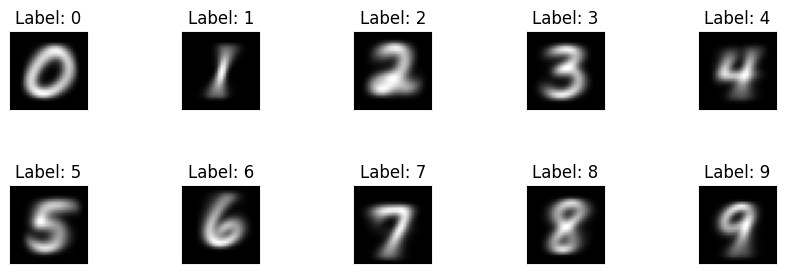

In [5]:
cifre_medie = [np.average(X_train[y_train==i],0) for i in range(10)]
# = np.array(avgs)
#avgs = avgs.reshape((avgs.shape[0], 28*28)).astype('float32')

plot_imgs_labels(cifre_medie,range(10))

In [14]:
def sim(vettore1,vettore2):
    vettore1_unitario = vettore1/norm(vettore1)
    vettore2_unitario = vettore2/norm(vettore2)
    similitudine = dot(vettore1_unitario,vettore2_unitario)
    return  similitudine


# ritorna l'indice del vettore più simile a vettore tra quelli in vettori
def argmax_sim(vettore, vettori):
    num_vettori = len(vettori)
    similitudini = np.zeros(num_vettori)
    for i in range(num_vettori):
        similitudini[i] = sim(vettore,vettori[i])
    return np.argmax(similitudini)


def predizione(image, cifre_medie):
    vettore = image.reshape((28*28,))
    vettori = [image.reshape((28*28,)) for image in cifre_medie]
    return argmax_sim(vettore,vettori)



## Fase 2: Inferenza (Predizione)

Durante la fase di inferenza, usiamo il modello addestrato (le immagini medie) per fare previsioni su nuovi dati:

1. Per ogni nuova immagine, calcoliamo la similarità coseno con ciascuna delle 10 immagini medie
2. Assegniamo all'immagine la cifra corrispondente all'immagine media più simile

Questo è il momento in cui il modello "lavora" su dati mai visti prima.

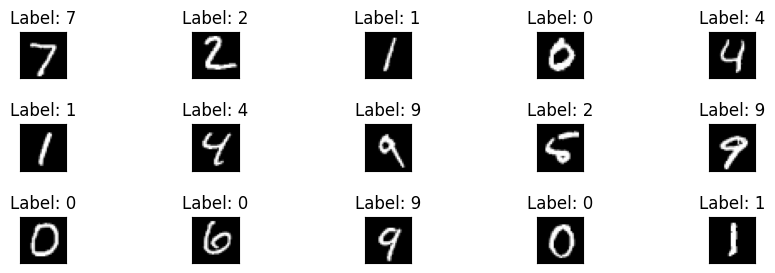

In [15]:
predizioni = [predizione(x,cifre_medie) for x in X_test]

plot_imgs_labels(X_test,predizioni,3,5)




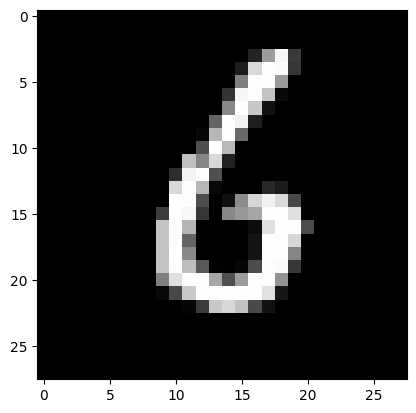

Valore predetto: 6


In [16]:
predizione_immagine_50 = predizione(X_test[50],cifre_medie)
plot_img(X_test[50])
print(f"Valore predetto: {predizione_immagine_50}")

## Valutazione del modello

Dopo aver fatto predizioni su tutte le immagini di test, possiamo calcolare l'accuratezza del nostro modello. L'accuratezza è semplicemente la percentuale di immagini classificate correttamente.


In [11]:
vettore_esiti_booleani = predizioni == y_test

accuracy = vettore_esiti_booleani.sum()/len(vettore_esiti_booleani)

print(accuracy)

0.8216


## Parametri del modello

Un aspetto fondamentale in machine learning è capire quanti "parametri" (o "pesi") ha il nostro modello. I parametri sono i valori che il modello apprende durante la fase di addestramento.

Nel nostro modello:
- Ogni immagine media è una matrice 28×28 (o equivalentemente un vettore di 784 elementi)
- Abbiamo 10 immagini medie (una per cifra)
- Quindi, abbiamo un totale di 10 × 784 = 7.840 parametri

Confrontiamo questo con altri modelli:
- Una rete neurale convoluzionale moderna per MNIST potrebbe avere centinaia di migliaia di parametri
- Modelli di deep learning per problemi complessi possono avere milioni o miliardi di parametri

Il nostro modello è estremamente semplice, ma ottiene comunque un'accuratezza dell'82% circa. Questo è un buon esempio di come a volte approcci semplici possano dare risultati sorprendentemente buoni!

## Conclusioni

Abbiamo costruito un classificatore di cifre scritte a mano che raggiunge circa l'82% di accuratezza usando solo la similarità coseno e le immagini medie. È un risultato notevole considerando la semplicità del metodo!

Questo approccio è un esempio di "apprendimento basato su modello": abbiamo creato un modello (le immagini medie) per ogni cifra e poi abbiamo classificato nuove immagini confrontandole con questi modelli.

Metodi più avanzati come le reti neurali possono raggiungere un'accuratezza superiore al 99% su questo dataset, ma richiedono maggiore complessità computazionale.

## Esercizi e attività

1. Visualizza alcune immagini che sono state classificate in modo errato. Puoi capire perché?
2. Calcola la matrice di confusione per vedere quali cifre vengono confuse più frequentemente.



## Importazione delle librerie necessarie

Le seguenti librerie sono necessarie per l'elaborazione dei dati, la visualizzazione e i calcoli matematici.

```python
from keras.datasets import mnist
from matplotlib import pyplot as plt
from oli_ai.mnist_lib import *
import numpy as np
from numpy.linalg import norm
from numpy import dot
```

## Caricamento del dataset MNIST

Carichiamo il dataset MNIST, che viene diviso in dati di addestramento (X_train, y_train) e dati di test (X_test, y_test).

```python
data = mnist.load_data()
(X_train, y_train), (X_test, y_test) = data
print(len(X_train))
print(len(X_test))
print(X_train[0].shape)
print(y_train[0])  
#X_train.shape
```

## Visualizzazione di una cifra

Qui visualizziamo la prima immagine dal set di addestramento per capire come appare una cifra.

```python
plot_img(X_train[0])
```

## Visualizzazione di più cifre con le loro etichette

Questa visualizzazione mostra diverse cifre con le loro etichette, permettendoci di capire la varietà di stili di scrittura presenti nel dataset.

```python
plot_imgs_labels(X_train,y_train, 3, 10)
```

## Fase 1: Apprendimento (Training)

Durante la fase di apprendimento, il modello "impara" dai dati di addestramento. Nel nostro caso, il modello è molto semplice:

1. Per ogni cifra (0-9), calcoliamo un'"immagine media" usando tutti gli esempi di quella cifra nel set di addestramento
2. Queste 10 immagini medie diventano il nostro "modello" - rappresentano come appare tipicamente ogni cifra

Questo è un esempio di apprendimento supervisionato, perché usiamo le etichette (y_train) per guidare l'apprendimento.

```python
cifre_5 = X_train[y_train==5]
media_cifra_5 = np.average(X_train[y_train==5],0)

plot_img(media_cifra_5)
```

## Visualizzazione di tutte le immagini medie

Ecco le immagini medie per tutte le cifre da 0 a 9. Questi sono i "prototipi" che il nostro modello utilizzerà per riconoscere nuove cifre.

```python
cifre_medie = [np.average(X_train[y_train==i],0) for i in range(10)]
# = np.array(avgs)
#avgs = avgs.reshape((avgs.shape[0], 28*28)).astype('float32')

plot_imgs_labels(cifre_medie,range(10))
```

## Definizione della similarità coseno

La similarità coseno è una misura matematica che indica quanto sono simili due vettori. Varia da -1 (completamente opposti) a 1 (identici). È calcolata come il prodotto scalare dei vettori normalizzati.

La funzione `sim()` calcola la similarità coseno tra due vettori.

```python
def sim(vettore1,vettore2):
    vettore1_unitario = vettore1/norm(vettore1)
    vettore2_unitario = vettore2/norm(vettore2)
    similitudine = dot(vettore1_unitario,vettore2_unitario)
    return  similitudine


# ritorna l'indice del vettore più simile a vettore tra quelli in vettori
def argmax_sim(vettore, vettori):
    num_vettori = len(vettori)
    similitudini = np.zeros(num_vettori)
    for i in range(num_vettori):
        similitudini[i] = sim(vettore,vettori[i])
    return np.argmax(similitudini)


def predizione(image, cifre_medie):
    vettore = image.reshape((28*28,))
    vettori = [image.reshape((28*28,)) for image in cifre_medie]
    return argmax_sim(vettore,vettori)
```

## Fase 2: Inferenza (Predizione)

Durante la fase di inferenza, usiamo il modello addestrato (le immagini medie) per fare previsioni su nuovi dati:

1. Per ogni nuova immagine, calcoliamo la similarità coseno con ciascuna delle 10 immagini medie
2. Assegniamo all'immagine la cifra corrispondente all'immagine media più simile

Questo è il momento in cui il modello "lavora" su dati mai visti prima.

```python
predizioni = [predizione(x,cifre_medie) for x in X_test]

plot_imgs_labels(X_test,predizioni,3,5)
```

## Valutazione del modello

Dopo aver fatto predizioni su tutte le immagini di test, possiamo calcolare l'accuratezza del nostro modello. L'accuratezza è semplicemente la percentuale di immagini classificate correttamente.

```python
vettore_esiti_booleani = predizioni == y_test

accuracy = vettore_esiti_booleani.sum()/len(vettore_esiti_booleani)

print(accuracy)
```

## Parametri del modello

Un aspetto fondamentale in machine learning è capire quanti "parametri" (o "pesi") ha il nostro modello. I parametri sono i valori che il modello apprende durante la fase di addestramento.

Nel nostro modello:
- Ogni immagine media è una matrice 28×28 (o equivalentemente un vettore di 784 elementi)
- Abbiamo 10 immagini medie (una per cifra)
- Quindi, abbiamo un totale di 10 × 784 = 7.840 parametri

Confrontiamo questo con altri modelli:
- Una rete neurale convoluzionale moderna per MNIST potrebbe avere centinaia di migliaia di parametri
- Modelli di deep learning per problemi complessi possono avere milioni o miliardi di parametri

Il nostro modello è estremamente semplice, ma ottiene comunque un'accuratezza dell'82% circa. Questo è un buon esempio di come a volte approcci semplici possano dare risultati sorprendentemente buoni!

## Conclusioni

Abbiamo costruito un classificatore di cifre scritte a mano che raggiunge circa l'82% di accuratezza usando solo la similarità coseno e le immagini medie. È un risultato notevole considerando la semplicità del metodo!

Questo approccio è un esempio di "apprendimento basato su modello": abbiamo creato un modello (le immagini medie) per ogni cifra e poi abbiamo classificato nuove immagini confrontandole con questi modelli.

Metodi più avanzati come le reti neurali possono raggiungere un'accuratezza superiore al 99% su questo dataset, ma richiedono maggiore complessità computazionale.

## Esercizi e attività

1. Prova a modificare la funzione di similarità e vedi se puoi migliorare l'accuratezza.
2. Visualizza alcune immagini che sono state classificate in modo errato. Puoi capire perché?
3. Come potremmo migliorare questo approccio semplice?
4. Calcola la matrice di confusione per vedere quali cifre vengono confuse più frequentemente.
5. Cosa succederebbe se invece dell'immagine media usassimo la mediana per ogni pixel?